In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import matplotlib.dates as mdates
from scipy.fft import fft, fftfreq

In [15]:
script_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'Senior Design', 'scripts'))
if script_dir not in sys.path:
    sys.path.append(script_dir)
from raw_data import create_df

### Loading in the CSV File
- make sure your file system is set up correctly
- set the ItemTest tag logging path to \sheets within this repository

In [16]:
raw_df = create_df(f"3_11_25_test9")

Found file: sheets\3_11_25_test9_2025-03-11_10-09-28.csv


In [17]:
a = 1 # choose which antenna you're reading
tag = "E280116060000209FF2351F4" # choose the tag
note = "" # add a note if you want to have more descriptive graph titles

In [18]:
# filtering df according to tag and antenna
clean_df = raw_df[raw_df["Antenna"] == a]
clean_df = clean_df[clean_df["EPC"] == tag]
clean_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'])



### Stats - can change these if you want

In [19]:
min_val = clean_df['RSSI'].min()
max_val = clean_df['RSSI'].max()

min_time = clean_df['Timestamp'].min()
max_time = clean_df['Timestamp'].max()

print(f"Range of RSSI: {min_val} to {max_val}")
print(f"Data Time Range: {max_time - min_time}")

avg_val = clean_df["RSSI"].mean()
print(f"Average RSSI: {avg_val}")

std_dev = clean_df["RSSI"].std()
median_val = clean_df["RSSI"].median()
variance_val = clean_df["RSSI"].var()
percentiles = clean_df["RSSI"].quantile([0.25, 0.5, 0.75])
skewness = clean_df["RSSI"].skew()
kurtosis = clean_df["RSSI"].kurtosis()
peak_to_peak = max_val - min_val

print(f"Standard Deviation: {std_dev}")
print(f"Median RSSI: {median_val}")
print(f"Variance: {variance_val}")
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")
print(f"Skewness: {skewness}") # no idea
print(f"Kurtosis: {kurtosis}") # no idea what this is
print(f"Peak-to-Peak Amplitude: {peak_to_peak}")

Range of RSSI: -37.0 to -33.0
Data Time Range: 0 days 00:01:49.480545
Average RSSI: -35.34952708512468
Standard Deviation: 0.7577296689467038
Median RSSI: -35.5
Variance: 0.5741542512020813
25th Percentile: -36.0
50th Percentile (Median): -35.5
75th Percentile: -35.0
Skewness: 0.7868930228395138
Kurtosis: 0.40650313653756376
Peak-to-Peak Amplitude: 4.0


### Plotting the Raw Data from the Reader
- This is the raw RSSI values that haven't been converted to distances
- The graph also displays some statistics as well
- If you want to modify/clean it, probably create a new dataframe

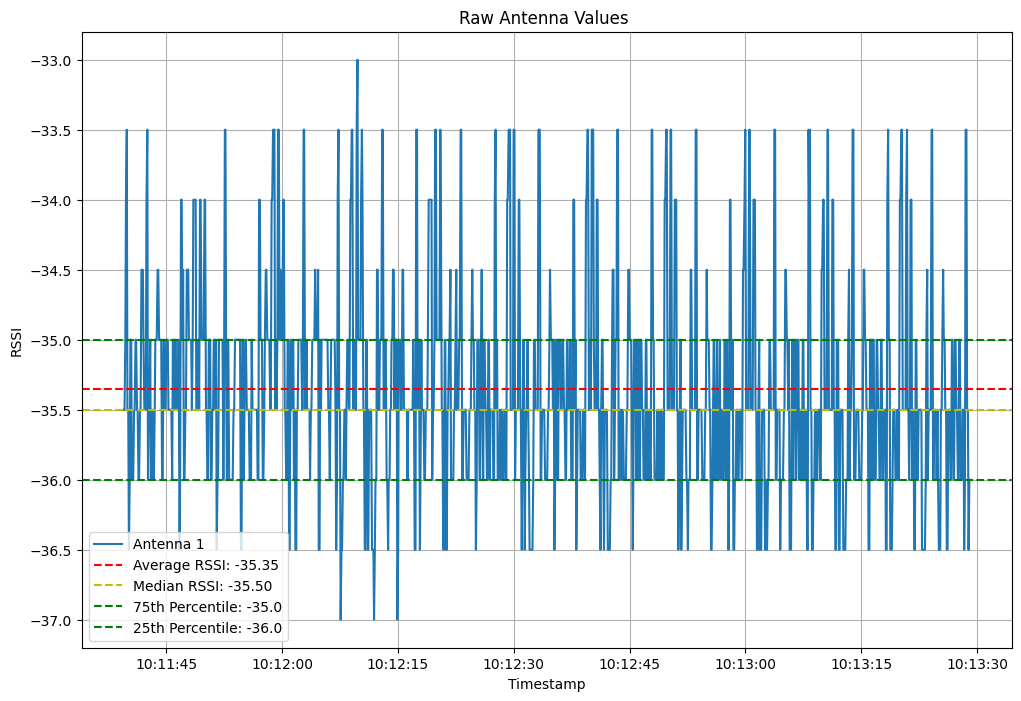

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(clean_df['Timestamp'], clean_df['RSSI'], label=f'Antenna {a}')
plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Average RSSI: {avg_val:.2f}')
plt.axhline(y=median_val, color='y', linestyle='--', label=f'Median RSSI: {median_val:.2f}')
plt.axhline(y=percentiles[0.75], color='g', linestyle='--', label=f"75th Percentile: {percentiles[0.75]}")
plt.axhline(y=percentiles[0.25], color='g', linestyle='--', label=f"25th Percentile: {percentiles[0.25]}")
plt.xlabel('Timestamp')
plt.ylabel('RSSI')
plt.title(f'Raw Antenna Values {note}')
plt.legend()
plt.grid(True)
plt.show()

### Remove the first 30 seconds of the Raw Readings
- need to determine if this is actually a good number

### Cut off Antenna Reeadings outside of interquartile range (25-75%)

In [22]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = clean_df['RSSI'].quantile(0.25)
Q3 = clean_df['RSSI'].quantile(0.75)

# Define the lower and upper bounds
lower_bound = Q1
upper_bound = Q3

clean_df['cutoff_RSSI'] = clean_df['RSSI'].clip(lower=lower_bound, upper=upper_bound)

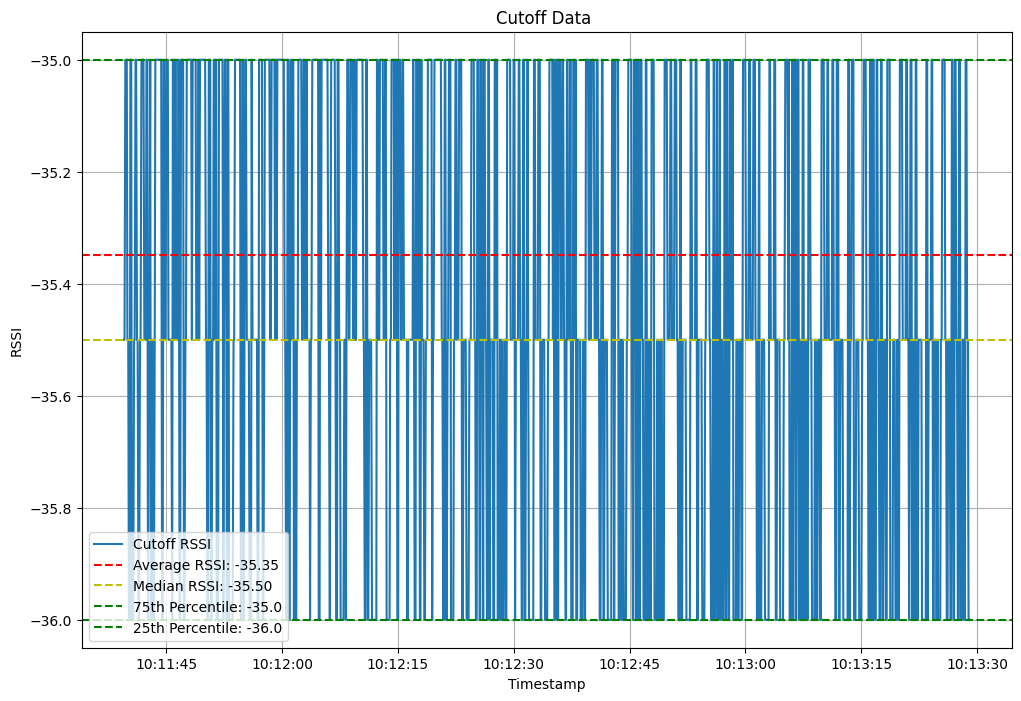

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(clean_df['Timestamp'], clean_df['cutoff_RSSI'], label=f'Cutoff RSSI')
plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Average RSSI: {avg_val:.2f}')
plt.axhline(y=median_val, color='y', linestyle='--', label=f'Median RSSI: {median_val:.2f}')
plt.axhline(y=percentiles[0.75], color='g', linestyle='--', label=f"75th Percentile: {percentiles[0.75]}")
plt.axhline(y=percentiles[0.25], color='g', linestyle='--', label=f"25th Percentile: {percentiles[0.25]}")
plt.xlabel('Timestamp')
plt.ylabel('RSSI')
plt.title(f'Cutoff Data {note}')
plt.legend()
plt.grid(True)
plt.show()

### Performing a Moving Average Filter on the Data
- Need to determine a good window size, modify the `filter_window` variable to see different graphs
- From what I've seen, a larger window is better
- We may need to have another filtering step before this so that the window points don't get skewed by outliers
- Could also experiment with a median filter or some other types of filters, idk

In [24]:
# moving average
filter_window = 50
clean_df["Norm_RSSI"] = clean_df["cutoff_RSSI"].rolling(window=filter_window).mean()

In [25]:
min_val = clean_df['Norm_RSSI'].min()
max_val = clean_df['Norm_RSSI'].max()

min_time = clean_df['Timestamp'].min()
max_time = clean_df['Timestamp'].max()

print(f"Range of RSSI: {min_val} to {max_val}")
print(f"Data Time Range: {max_time - min_time}")

avg_val = clean_df["Norm_RSSI"].mean()
print(f"Average RSSI: {avg_val}")

std_dev = clean_df["Norm_RSSI"].std()
median_val = clean_df["Norm_RSSI"].median()
variance_val = clean_df["Norm_RSSI"].var()
percentiles = clean_df["Norm_RSSI"].quantile([0.25, 0.5, 0.75])
skewness = clean_df["Norm_RSSI"].skew()
kurtosis = clean_df["Norm_RSSI"].kurtosis()
peak_to_peak = max_val - min_val

print(f"Standard Deviation: {std_dev}")
print(f"Median RSSI: {median_val}")
print(f"Variance: {variance_val}")
print(f"25th Percentile: {percentiles[0.25]}")
print(f"50th Percentile (Median): {percentiles[0.5]}")
print(f"75th Percentile: {percentiles[0.75]}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")
print(f"Peak-to-Peak Amplitude: {peak_to_peak}")

Range of RSSI: -35.61 to -35.22
Data Time Range: 0 days 00:01:49.480545
Average RSSI: -35.46262118491921
Standard Deviation: 0.09999885956239157
Median RSSI: -35.49
Variance: 0.009999771913778913
25th Percentile: -35.54
50th Percentile (Median): -35.49
75th Percentile: -35.39
Skewness: 0.6148566133889686
Kurtosis: -0.763339521835499
Peak-to-Peak Amplitude: 0.39000000000000057


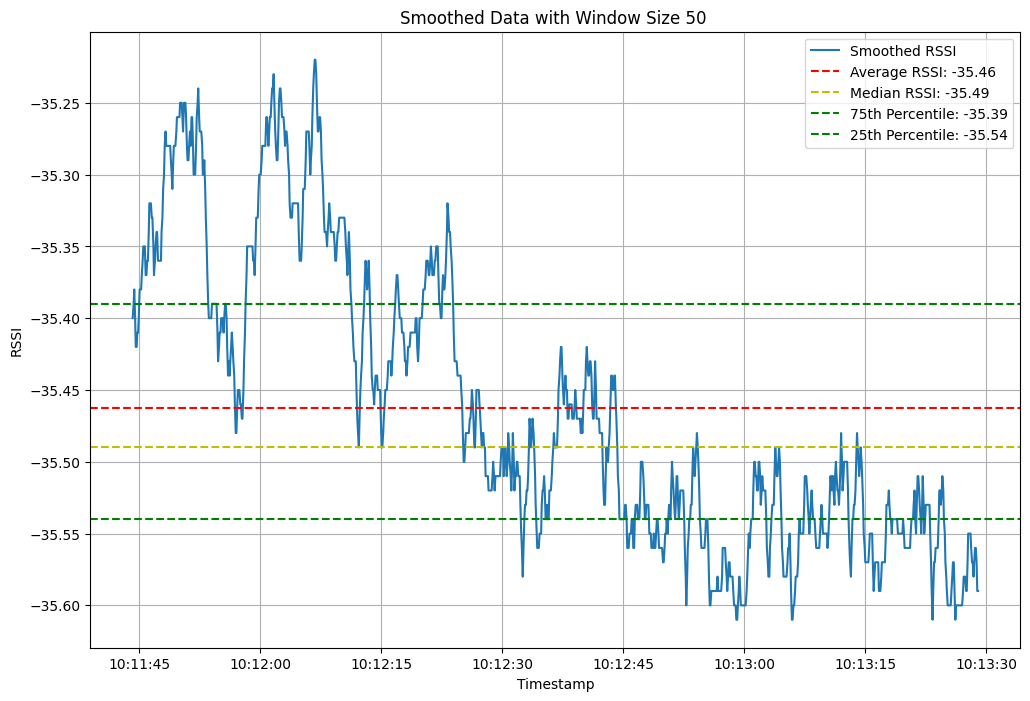

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(clean_df['Timestamp'], clean_df['Norm_RSSI'], label=f'Smoothed RSSI')
plt.axhline(y=avg_val, color='r', linestyle='--', label=f'Average RSSI: {avg_val:.2f}')
plt.axhline(y=median_val, color='y', linestyle='--', label=f'Median RSSI: {median_val:.2f}')
plt.axhline(y=percentiles[0.75], color='g', linestyle='--', label=f"75th Percentile: {percentiles[0.75]}")
plt.axhline(y=percentiles[0.25], color='g', linestyle='--', label=f"25th Percentile: {percentiles[0.25]}")
plt.xlabel('Timestamp')
plt.ylabel('RSSI')
plt.title(f'Smoothed Data with Window Size {filter_window} {note}')
plt.legend()
plt.grid(True)
plt.show()

### More Data Cleaning Ideas
- Ignore the first 30ish seconds of data, those seem to be very noisy
- Regression